In [59]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

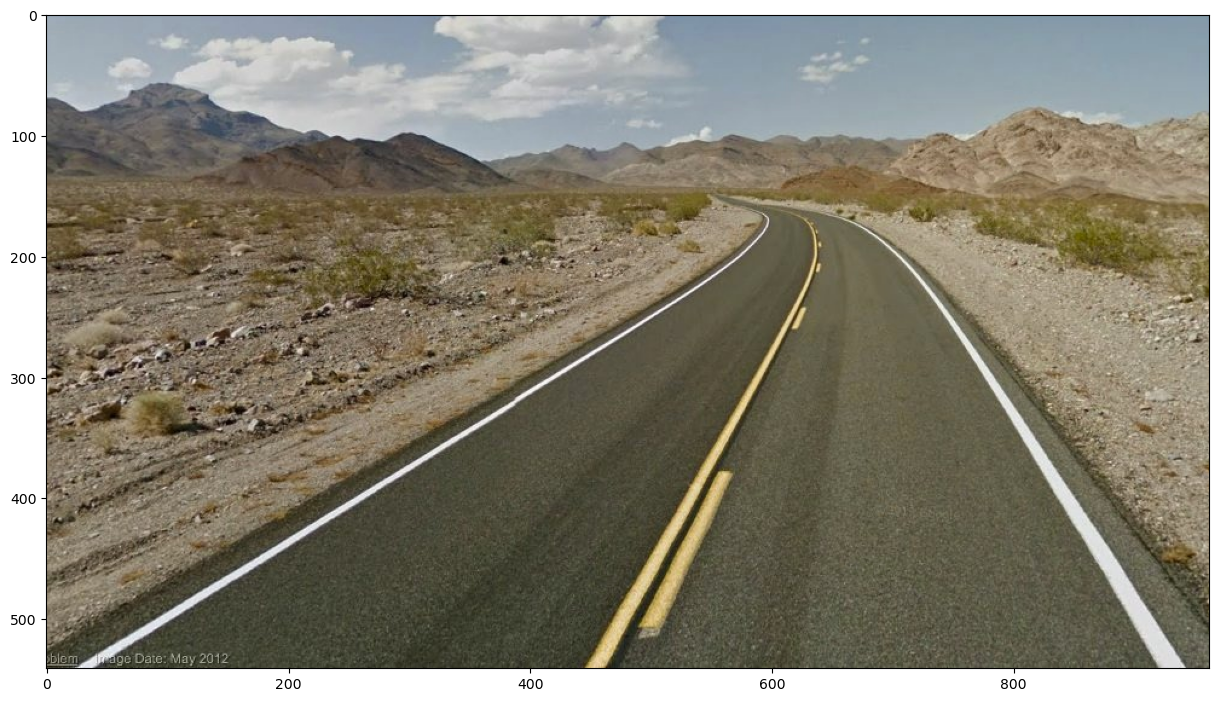

In [60]:
img = cv2.imread('C:/r_d/dashcam2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.resize(img, None, fx=0.5, fy=0.5) the image is already small
plt.imshow(img)

(<AxesSubplot: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

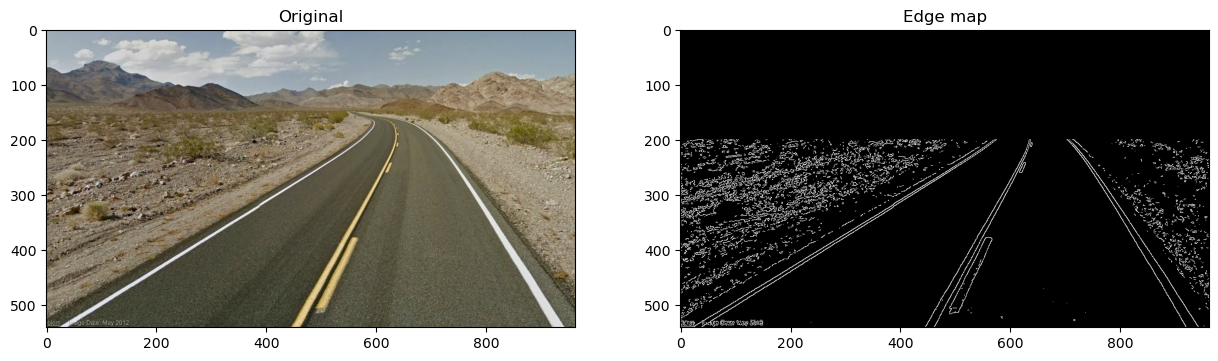

In [61]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
# the road makes a lot of noise
edges = cv2.Canny(gray, threshold1=200, threshold2=250)

# We are only interseted in the road so we will remove everything above the horizon
edges[0:200] = 0

# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

In [62]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
lines = cv2.HoughLines(edges, rho=2, theta=2*np.pi/180, threshold=220)
# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]

(<AxesSubplot: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

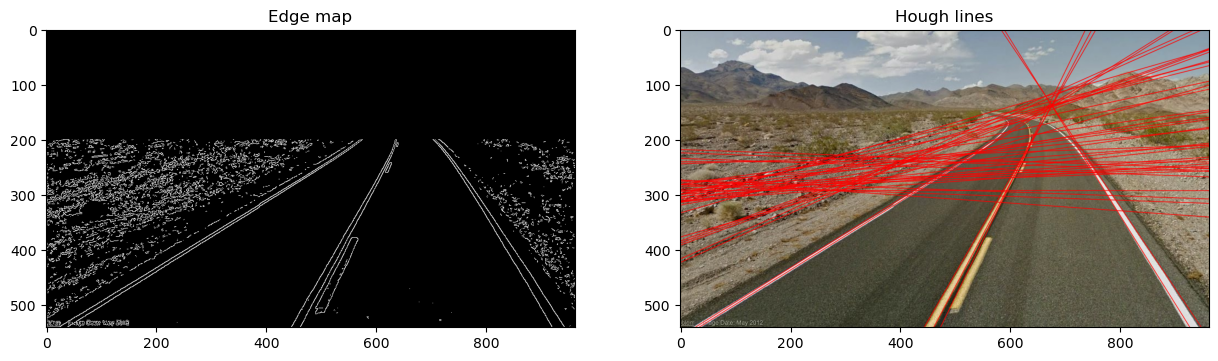

In [63]:
# Plot the resulting Hough lines
result = np.copy(img)
        
for line in lines:
    rho = np.array(line[0], dtype=np.float64)
    theta = np.array(line[1], dtype=np.float64)
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

In [64]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees). 
filtered_lines = []
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    theta = np.array(line[1], dtype=np.float64)
    # Keep line if theta is not horizontal
    if theta<1.1 or theta>2.4 :
        filtered_lines.append(line)

(<AxesSubplot: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

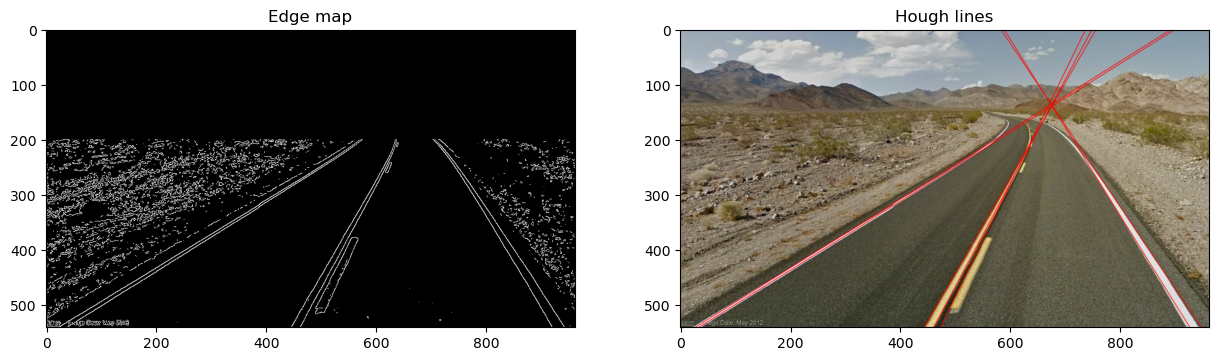

In [65]:
# Again, let's plot the resulting filtered lines
result = np.copy(img)
for line in filtered_lines:
    rho = np.array(line[0], dtype=np.float64)
    theta = np.array(line[1], dtype=np.float64)
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

In [66]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

C:\Users\user\anaconda3\envs\cv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\envs\cv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([[ 6.55000000e+02,  5.23598790e-01],
       [-4.83000000e+02,  2.54818058e+00],
       [ 4.77000000e+02,  1.01229095e+00],
       [-4.99000000e+02,  2.58308721e+00],
       [ 6.62000000e+02,  4.71238896e-01],
       [ 4.73000000e+02,  1.01229095e+00]])

(<AxesSubplot: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

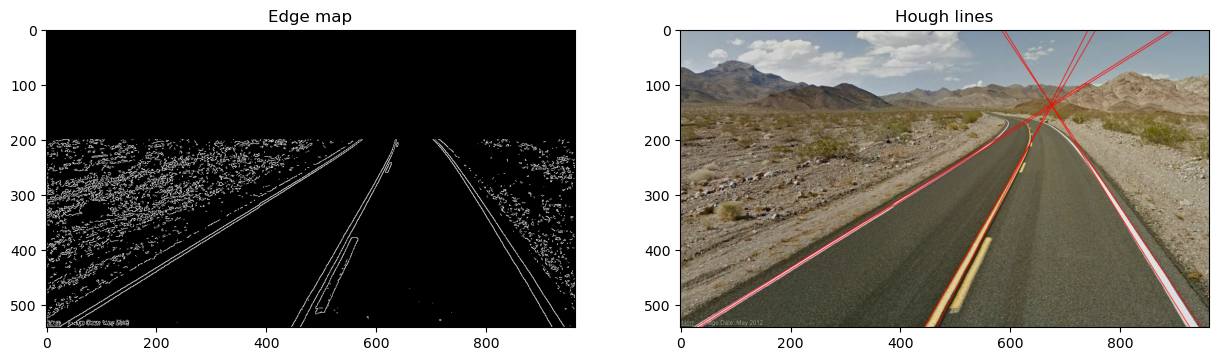

In [67]:

# Again, let's plot the resulting filtered lines
result = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho = np.array(line[0], dtype=np.float64)
    theta = np.array(line[1], dtype=np.float64)
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

In [68]:
# Questions
# 1) the lines stop being accurate at the end of the road
# 2) yes. If the value is too big, the number of lines will be too big
# 3) yes. If it is too big, not all lines will appear. If it is too small, too much lines will appear